## Data Preparation 

In [11]:
import JuliaDB
using JuliaDB: ML,table
const Jdb = JuliaDB
using VegaDatasets

In [12]:
cars = dataset("cars") |> table

Table with 406 rows, 9 columns:
Columns:
#  colname           type
────────────────────────────────────────────
1  Name              String
2  Miles_per_Gallon  Union{Missing, Float64}
3  Cylinders         Int64
4  Displacement      Float64
5  Horsepower        Union{Missing, Int64}
6  Weight_in_lbs     Int64
7  Acceleration      Float64
8  Year              String
9  Origin            String

In [13]:
ML.schema(cars)

Dict{Symbol,Any} with 9 entries:
  :Cylinders        => Continous(μ=5.475369458128076, σ=1.7121596315485288)
  :Horsepower       => Maybe{Continuous}(Continous(μ=105.08250000000002, σ=38.7…
  :Displacement     => Continous(μ=194.77955665024618, σ=104.92245837948875)
  :Weight_in_lbs    => Continous(μ=2979.4137931034484, σ=847.0043282393509)
  :Miles_per_Gallon => Maybe{Continuous}(Continous(μ=23.514572864321607, σ=7.81…
  :Year             => nothing
  :Acceleration     => Continous(μ=15.51970443349754, σ=2.803358816342545)
  :Origin           => nothing
  :Name             => nothing

In [14]:
cars_schema = ML.schema(cars,hints = Dict(
        :Cylinders=>ML.Categorical
    )
)

Dict{Symbol,Any} with 9 entries:
  :Cylinders        => Categorical([8, 4, 6, 3, 5])
  :Horsepower       => Maybe{Continuous}(Continous(μ=105.08250000000002, σ=38.7…
  :Displacement     => Continous(μ=194.77955665024618, σ=104.92245837948875)
  :Weight_in_lbs    => Continous(μ=2979.4137931034484, σ=847.0043282393509)
  :Miles_per_Gallon => Maybe{Continuous}(Continous(μ=23.514572864321607, σ=7.81…
  :Year             => nothing
  :Acceleration     => Continous(μ=15.51970443349754, σ=2.803358816342545)
  :Origin           => nothing
  :Name             => nothing

In [15]:
input_schema, output_schema = ML.splitschema(cars_schema,:Displacement);

In [16]:
input_schema

Dict{Symbol,Any} with 8 entries:
  :Cylinders        => Categorical([8, 4, 6, 3, 5])
  :Horsepower       => Maybe{Continuous}(Continous(μ=105.08250000000002, σ=38.7…
  :Weight_in_lbs    => Continous(μ=2979.4137931034484, σ=847.0043282393509)
  :Miles_per_Gallon => Maybe{Continuous}(Continous(μ=23.514572864321607, σ=7.81…
  :Year             => nothing
  :Acceleration     => Continous(μ=15.51970443349754, σ=2.803358816342545)
  :Origin           => nothing
  :Name             => nothing

In [17]:
input = ML.featuremat(input_schema,cars)

11×406 LinearAlgebra.Adjoint{Float32,Array{Float32,2}}:
  1.0        1.0        1.0       …   0.0        0.0        0.0     
  0.0        0.0        0.0           1.0        1.0        1.0     
  0.0        0.0        0.0           0.0        0.0        0.0     
  0.0        0.0        0.0           0.0        0.0        0.0     
  0.0        0.0        0.0           0.0        0.0        0.0     
  0.0        0.0        0.0       …   0.0        0.0        0.0     
  0.642721   1.54551    1.1586       -0.543801  -0.672771  -0.595389
  0.619343   0.842482   0.53906      -0.80804   -0.418432  -0.306272
  0.0        0.0        0.0           0.0        0.0        0.0     
 -0.705551  -1.08938   -0.705551      1.08565    0.573879   0.957708
 -1.25553   -1.43389   -1.61225   …  -1.39822    1.09879    1.38416 

In [18]:
output = ML.featuremat(output_schema,cars)

1×406 LinearAlgebra.Adjoint{Float32,Array{Float32,2}}:
 1.06956  1.47938  1.1744  1.04096  1.0219  …  -0.56975  -0.712713  -0.722243

In [44]:
using Random
function partitionTrainTest(input,output, at = 0.8)
    @assert size(input,2) == size(output,2)
    n = size(input,2)
    idx = shuffle(1:n)
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    return input[:,train_idx], output[:,train_idx], input[:,test_idx],output[:,test_idx]
end

partitionTrainTest (generic function with 2 methods)

In [45]:
train_input,train_output,test_input,test_output = partitionTrainTest(input,output,0.7)

(Float32[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 1.0 0.0; … ; -0.4240762 0.31799284 … -0.44966477 0.24122709; -0.97015923 1.9549034 … 1.2414734 -1.0415022], Float32[1.0219017 -0.9319221 … -0.9319221 -0.2552319], Float32[0.0 0.0 … 1.0 1.0; 1.0 1.0 … 0.0 0.0; … ; -0.06583597 0.4715244 … -0.8462879 -1.4732083; -0.54210126 -0.29240084 … -0.22105783 -1.4338887], Float32[-0.6936509 -0.7222434 … 1.4793824 1.7939005])

## Use Flux

In [46]:
import Flux
const Fx = Flux

Flux

In [47]:
model = Fx.Chain(
    Fx.Dense(ML.width(input_schema),5,Fx.relu),
    Fx.Dense(5,ML.width(output_schema))
)

loss(x, y) = Flux.mse(model(x), y)
#loss(x,y) = Fx.crossentropy(model(x),y)
opt = Flux.ADAM(0.001)

Flux.Optimise.ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [48]:
data = [(train_input, train_output)] #|> gpu;

In [49]:
evalcb = Fx.throttle(() -> @show(loss(first(data)...)), 0.1);
for i = 1:1000
  Fx.train!(loss, Fx.params(model),data, opt, cb = evalcb)
end

loss(first(data)...) = 3.6375585f0 (tracked)
loss(first(data)...) = 0.10504713f0 (tracked)
loss(first(data)...) = 0.049422108f0 (tracked)


In [50]:
yhat=model(test_input)
y=test_output

1×122 Array{Float32,2}:
 -0.693651  -0.722243  -0.855675  …  1.95592  -0.998638  1.47938  1.7939

rmse=0.2095043


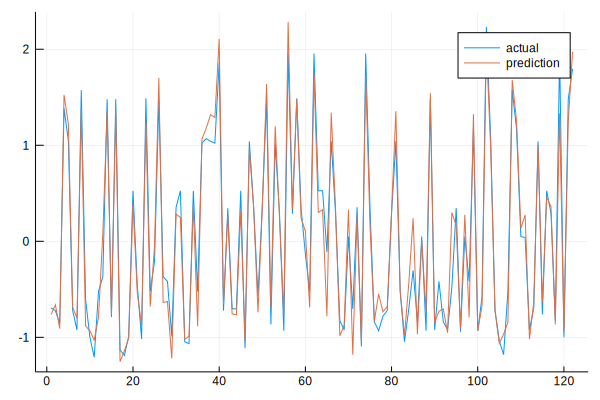

In [64]:
using Plots
using Statistics
sqrt((y .- yhat.data).^2 |> mean ) |> x-> println("rmse=",x)
plot([y' yhat.data'],lab=["actual","prediction"])

## Using Knet

In [65]:
import Knet
using Flux: onecold

┌ Info: Precompiling Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1242


In [66]:
Atype = Knet.gpu() >= 0 ? KnetArray{Float32} : Array{Float32}
# setup weight parameters
# cars data: input=11, hidden=>5, output=>1,
wmlp=map(Atype, [ 0.1*randn(5,11), zeros(5,1),
                  0.1*randn(1,5),  zeros(1,1) ])

4-element Array{Array{Float32,2},1}:
 [0.15638451 0.08042237 … 0.09426158 0.052824635; 0.14081827 0.015274953 … 0.10766815 0.06627576; … ; 0.0012411039 -0.1322762 … -0.15162571 -0.052992847; 0.13441737 0.05228636 … 0.089399256 0.09475982]
 [0.0; 0.0; … ; 0.0; 0.0]                                                                                                                                                                                
 [-0.09414563 0.14063123 … -0.07491995 -0.09777867]                                                                                                                                                      
 [0.0]                                                                                                                                                                                                   

In [67]:
function knetpredict(w,x)
    for i=1:2:length(w)
        x = w[i]*Knet.mat(x) .+ w[i+1]
        if i<length(w)-1
            x = max.(0,x)
        end
    end
    return x
end

knetpredict (generic function with 1 method)

In [68]:
# SGD training loop
function train!(w, data; lr=.1)
    for (x,y) in data
        dw = lossgradient(w, x, y)
        for i in 1:length(w)
            w[i] -= lr * dw[i]
        end
    end
    return w
end


train! (generic function with 1 method)

In [74]:
loss(w,x,ygold) = Knet.logsumexp(knetpredict(w,x),ygold); # nll is negative log likelihood
lossgradient = Knet.grad(loss);

In [75]:
x=train_input
ygold=(train_output)

loss(wmlp,x,ygold)

@time weights = [ copy(train!(wmlp, [(x, ygold)])) for epoch=1:1000 ]

losses = [ loss(w,x,ygold) for w in weights ]

MethodError: MethodError: no method matching logsumexp(::Array{Float32,2}, ::Array{Float32,2})
Closest candidates are:
  logsumexp(::Any; dims) at /Users/ppalmes/.julia/packages/Knet/IIjk8/src/loss.jl:225

In [ ]:
println("losses:")
println("====")
[x for x in losses[end-10:end]]

In [ ]:
using Plots
gr()
Plots.plot(losses,xlabel="epochs",ylabel="Loss")

In [ ]:
res=argmax(knetpredict(wmlp,train_input)) .== argmax(train_output)
sum(res)/length(res)*100

In [ ]:
res=argmax(knetpredict(wmlp,test_input)) .== argmax(test_output)
k_accuracy = sum(res)/length(res)*100

In [97]:
using TensorFlow
using Distributions
using Printf

# Generate some synthetic data
x = randn(100, 50)
w = randn(50, 10)
y_prob = exp.(x*w)
y_prob ./= sum(y_prob,dims=2)

function draw(probs)
    y = zeros(size(probs))
    for i in 1:size(probs, 1)
        idx = rand(Categorical(probs[i, :]))
        y[i, idx] = 1
    end
    return y
end

y = draw(y_prob)

# Build the model
sess = Session(Graph())

X = placeholder(Float64, shape=[-1, 50])
Y_obs = placeholder(Float64, shape=[-1, 10])

variable_scope("logisitic_model"; initializer=Normal(0, .001)) do
    global W = get_variable("W", [50, 10], Float64)
    global B = get_variable("B", [10], Float64)
end

Y=nn.softmax(X*W + B)

Loss = -reduce_sum(log(Y).*Y_obs)
optimizer = train.AdamOptimizer()
minimize_op = train.minimize(optimizer, Loss)
saver = train.Saver()

# Run training
run(sess, global_variables_initializer())
checkpoint_path = mktempdir()
@info("Checkpoint files saved in $checkpoint_path")
for epoch in 1:100
    cur_loss, _ = run(sess, [Loss, minimize_op], Dict(X=>x, Y_obs=>y))
    println(@sprintf("Current loss is %.2f.", cur_loss))
    train.save(saver, sess, joinpath(checkpoint_path, "logistic"), global_step=epoch)
end

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = make_py_graph(::Array{UInt8,1}) at py.jl:51
└ @ Main ~/.julia/packages/TensorFlow/q9pY2/src/py.jl:51
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = make_py_graph(::Array{UInt8,1}) at py.jl:52
└ @ Main ~/.julia/packages/TensorFlow/q9pY2/src/py.jl:52
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_with(::getfield(Main, Symbol("##3#4")){Array{UInt8,1}}, ::PyObject) at py.jl:19
└ @ Main ~/.julia/packages/TensorFlow/q9pY2/src/py.jl:19
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getpropert

RemoteException: On worker 2:
type KeyError has no field val
getproperty at ./Base.jl:20
#3 at /Users/ppalmes/.julia/packages/TensorFlow/q9pY2/src/py.jl:44
py_with at /Users/ppalmes/.julia/packages/TensorFlow/q9pY2/src/py.jl:20
make_py_graph at /Users/ppalmes/.julia/packages/TensorFlow/q9pY2/src/py.jl:52
py_gradients at /Users/ppalmes/.julia/packages/TensorFlow/q9pY2/src/py.jl:75
#29 at /Users/ppalmes/.julia/packages/TensorFlow/q9pY2/src/TensorFlow.jl:189
#116 at /Users/sabae/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.2/Distributed/src/process_messages.jl:307
run_work_thunk at /Users/sabae/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.2/Distributed/src/process_messages.jl:79
run_work_thunk at /Users/sabae/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.2/Distributed/src/process_messages.jl:88
#102 at ./task.jl:268